Run Linear regression on Home price and calculate the RMSE over all the counties

In [30]:
import pandas as pd

# Load the dataset
file_path = './data/cleaned_all_datasets_joined.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand the structure of the dataset
data.head()


county state  FIPS_Code        date  year  \
0  Los Angeles County    CA       6037  2019-01-31  2019   
1         Cook County    IL      17031  2019-01-31  2019   
2         Cook County    IL      17031  2019-01-31  2019   
3         Cook County    IL      17031  2019-01-31  2019   
4         Cook County    IL      17031  2019-01-31  2019   

   resident_population_per_county  totallisting_per_county  total_population  \
0                       10011.602                  18131.0        10081570.0   
1                        5145.326                  21464.0         5198275.0   
2                        5145.326                  21464.0         5198275.0   
3                        5145.326                  21464.0         5198275.0   
4                        5145.326                  21464.0         5198275.0   

   pct_male  pct_female  ...  pct_race_pacific  pct_race_others  pct_hispanic  \
0      49.3        50.7  ...               0.6             22.2          48.5   
1      48.5        51.5  ...               0.1             10.3          25.3   
2      48.5        51.5  ...               0.1             10.3          25.3   
3      48.5        51.5  ...               0.1             10.3          25.3   
4      48.5        51.5  ...               0.1             10.3          25.3   

   median_household_income  remote_imputed  top_metro  neighbour_level  \
0                3316795.0        0.058736      False              NaN   
1                1972108.0        0.054434       True              0.0   
2                1972108.0        0.054434       True              1.0   
3                1972108.0        0.054434       True              1.0   
4                1972108.0        0.054434       True              1.0   

   neighbour_top_metro  TOP_METRO     home_price  
0                False      False  631772.163507  
1                 True       True  232423.290403  
2                False       True  232423.290403  
3                False       True  232423.290403  
4                False       True  232423.290403  

[5 rows x 26 columns]

In [32]:
# Convert the 'date' column to datetime format if not already
data['date'] = pd.to_datetime(data['date'])

# Sort the data by county and date to ensure proper time series order
data = data.sort_values(by=['county', 'date'])

# Add lagged home price features for each county
data['home_price_lag_1'] = data.groupby('county')['home_price'].shift(1)
data['home_price_lag_2'] = data.groupby('county')['home_price'].shift(2)

# Check the updated dataset for lagged features
data.head()

county state  FIPS_Code       date  year  \
6163   Abbeville County    SC      45001 2019-01-31  2019   
13686  Abbeville County    SC      45001 2019-02-28  2019   
21226  Abbeville County    SC      45001 2019-03-31  2019   
28765  Abbeville County    SC      45001 2019-04-30  2019   
36307  Abbeville County    SC      45001 2019-05-31  2019   

       resident_population_per_county  totallisting_per_county  \
6163                              NaN                      NaN   
13686                             NaN                      NaN   
21226                             NaN                      NaN   
28765                             NaN                      NaN   
36307                             NaN                      NaN   

       total_population  pct_male  pct_female  ...  pct_hispanic  \
6163            24627.0      48.5        51.5  ...           1.5   
13686           24627.0      48.5        51.5  ...           1.5   
21226           24627.0      48.5        51.5  ...           1.5   
28765           24627.0      48.5        51.5  ...           1.5   
36307           24627.0      48.5        51.5  ...           1.5   

       median_household_income  remote_imputed  top_metro  neighbour_level  \
6163                    9660.0        0.051249      False              NaN   
13686                   9660.0        0.051249      False              NaN   
21226                   9660.0        0.051249      False              NaN   
28765                   9660.0        0.051249      False              NaN   
36307                   9660.0        0.051249      False              NaN   

       neighbour_top_metro  TOP_METRO     home_price  home_price_lag_1  \
6163                 False      False  120189.497714               NaN   
13686                False      False  119917.491037     120189.497714   
21226                False      False  120065.257287     119917.491037   
28765                False      False  120130.022503     120065.257287   
36307                False      False  120300.775688     120130.022503   

       home_price_lag_2  
6163                NaN  
13686               NaN  
21226     120189.497714  
28765     119917.491037  
36307     120065.257287  

[5 rows x 28 columns]

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare results storage
results = []

# Remove rows with missing lag values as they are required for regression
data = data.dropna(subset=['home_price_lag_1', 'home_price_lag_2'])

# Group by county and fit a regression model for each
for county, group in data.groupby('county'):
    # Prepare features (lagged prices) and target (current home price)
    X = group[['home_price_lag_1', 'home_price_lag_2']].values
    y = group['home_price'].values

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Predict and calculate RMSE
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # Store results
    results.append({
        'county': county,
        'coeff_lag_1': model.coef_[0],
        'coeff_lag_2': model.coef_[1],
        'intercept': model.intercept_,
        'rmse': rmse
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results to the user
print(results_df)


                county  coeff_lag_1  coeff_lag_2     intercept          rmse
0     Abbeville County     1.866308    -0.870343    811.493677    588.229479
1        Acadia Parish     1.697754    -0.733804   5305.883290    702.983859
2      Accomack County     1.723954    -0.727681   1084.717552    931.691864
3           Ada County     0.998241     0.001604     91.501901    613.368486
4         Adair County     0.686622    -0.199080  69188.218698  20785.873640
...                ...          ...          ...           ...           ...
1833      Young County     1.835166    -0.838839    631.006934    575.198348
1834       Yuba County     1.928962    -0.933773   1846.106302    917.182175
1835       Yuma County    -0.005058     0.997615   3167.938272   1473.522256
1836     Zapata County     1.812980    -0.833700   2704.161778    823.824026
1837     Zavala County     1.778675    -0.797872   1570.040992    585.903062

[1838 rows x 5 columns]


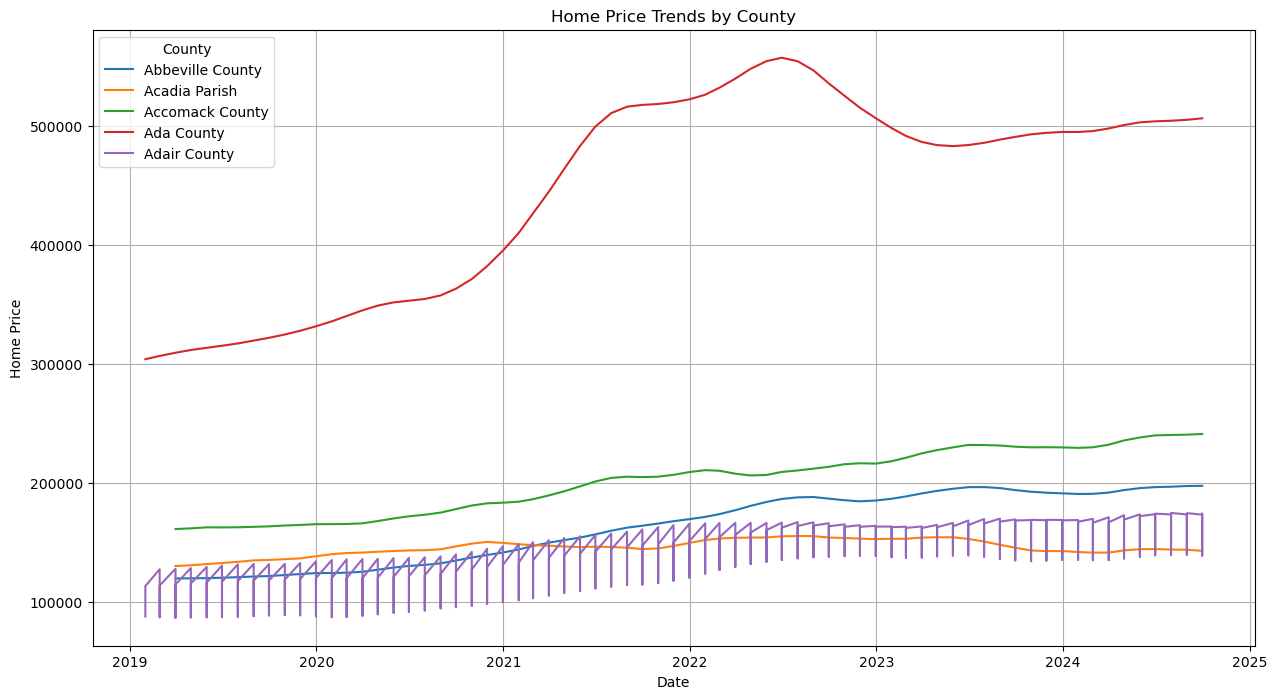

In [36]:
import matplotlib.pyplot as plt

# Select a few counties to plot trends (for visualization purposes)
selected_counties = data['county'].unique()[:5]

# Plot home price trends for selected counties
plt.figure(figsize=(15, 8))
for county in selected_counties:
    county_data = data[data['county'] == county]
    plt.plot(county_data['date'], county_data['home_price'], label=county)

plt.title('Home Price Trends by County')
plt.xlabel('Date')
plt.ylabel('Home Price')
plt.legend(title='County')
plt.grid(True)
plt.show()


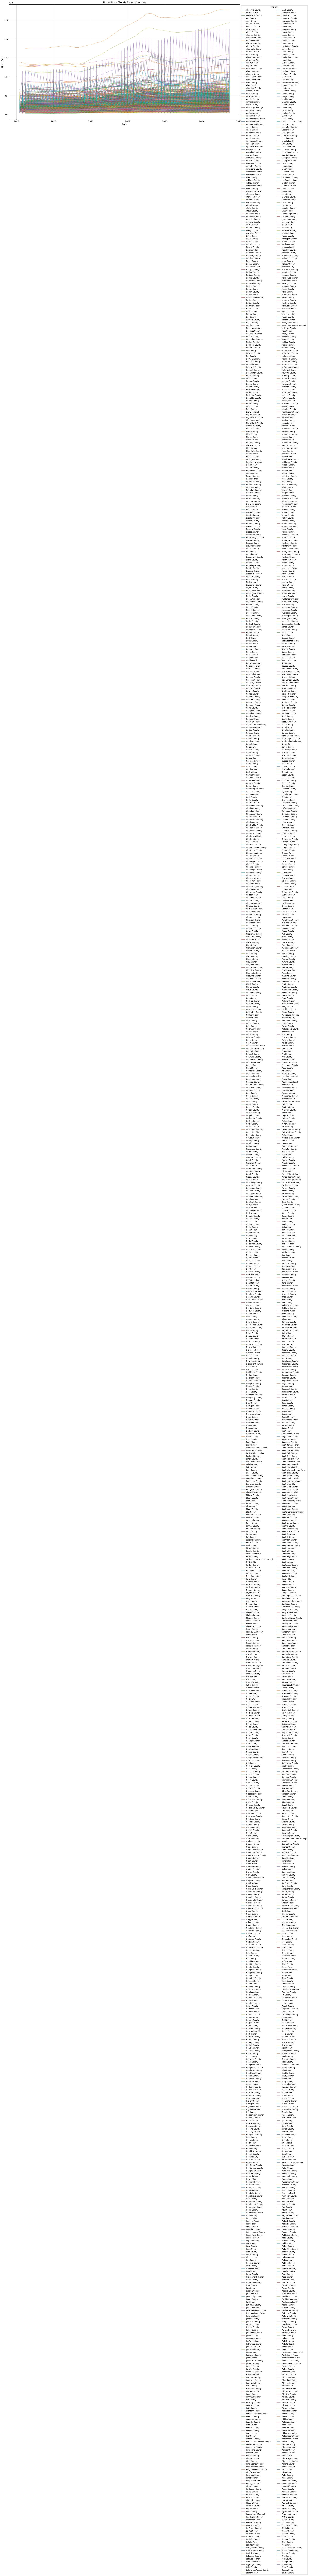

In [38]:
# Plot home price trends for all counties
plt.figure(figsize=(20, 10))
for county in data['county'].unique():
    county_data = data[data['county'] == county]
    plt.plot(county_data['date'], county_data['home_price'], alpha=0.7, linewidth=0.8, label=county)

plt.title('Home Price Trends for All Counties')
plt.xlabel('Date')
plt.ylabel('Home Price')
plt.legend(title='County', loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize='small')
plt.grid(True)
plt.show()


In [40]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Reloading the dataset and reprocessing due to session reset
file_path = './data/cleaned_all_datasets_joined.csv'
data = pd.read_csv(file_path)

# Convert the 'date' column to datetime and sort
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(by=['county', 'date'])

# Add lag features
data['home_price_lag_1'] = data.groupby('county')['home_price'].shift(1)
data['home_price_lag_2'] = data.groupby('county')['home_price'].shift(2)

# Drop rows with missing lag values
data = data.dropna(subset=['home_price_lag_1', 'home_price_lag_2'])

# Initialize storage for results
results = []

# Time series regression for each county
for county, group in data.groupby('county'):
    X = group[['home_price_lag_1', 'home_price_lag_2']].values
    y = group['home_price'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    results.append({
        'county': county,
        'coeff_lag_1': model.coef_[0],
        'coeff_lag_2': model.coef_[1],
        'intercept': model.intercept_,
        'rmse': rmse
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Calculate the average RMSE
average_rmse = results_df['rmse'].mean()

average_rmse


8331.909913889236

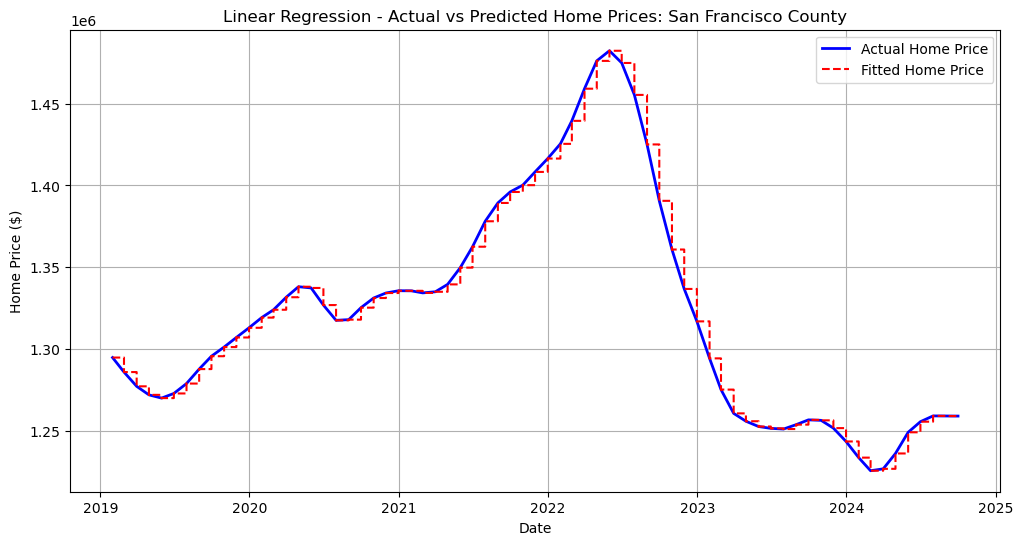

In [42]:
# Filter data for San Francisco County
sf_data = data[data['county'] == 'San Francisco County']

# Prepare features (lagged home prices) and target (current home price)
X_sf = sf_data[['home_price_lag_1', 'home_price_lag_2']].values
y_sf = sf_data['home_price'].values

# Fit a linear regression model
sf_model = LinearRegression()
sf_model.fit(X_sf, y_sf)

# Predict and calculate RMSE
y_sf_pred = sf_model.predict(X_sf)
sf_rmse = np.sqrt(mean_squared_error(y_sf, y_sf_pred))

# Coefficients and intercept
sf_coeff_lag_1 = sf_model.coef_[0]
sf_coeff_lag_2 = sf_model.coef_[1]
sf_intercept = sf_model.intercept_

sf_results = {
    "County": "San Francisco",
    "Coeff_Lag_1": sf_coeff_lag_1,
    "Coeff_Lag_2": sf_coeff_lag_2,
    "Intercept": sf_intercept,
    "RMSE": sf_rmse
}

sf_results

# Plot actual vs predicted home prices for San Francisco County
plt.figure(figsize=(12, 6))
plt.plot(sf_data['date'], y_sf, label='Actual Home Price', linewidth=2, color='blue')
plt.plot(sf_data['date'], y_sf_pred, label='Fitted Home Price', linestyle='--', color='red')
plt.title('Linear Regression - Actual vs Predicted Home Prices: San Francisco County')
plt.xlabel('Date')
plt.ylabel('Home Price ($)')
plt.legend()
plt.grid(True)
plt.show()


Run ARIMA for the Home price and calculate the RMSE for all the counties

C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be give

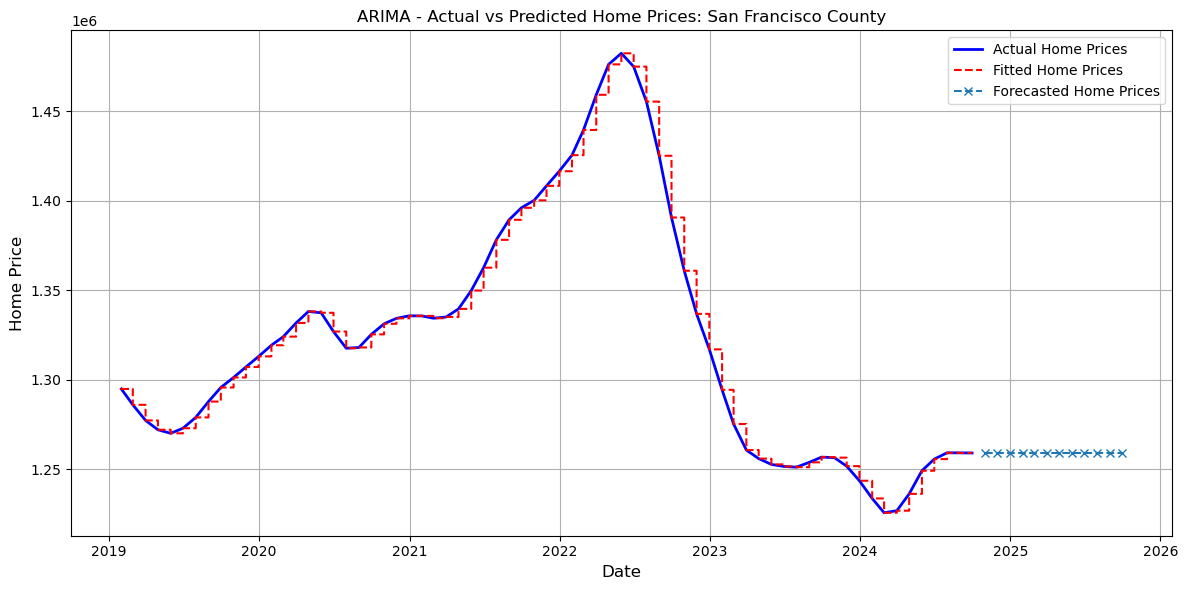

C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versio

Average RMSE: 30654.72952594694


In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import json

# Load the dataset
file_path = './data/cleaned_all_datasets_joined.csv'
data = pd.read_csv(file_path)

# Helper function to fit ARIMA for a single county
def run_arima_for_county(county_name):
    try:
        # Filter data for the specific county
        county_data = data[data['county'] == county_name].copy()
        county_data['date'] = pd.to_datetime(county_data['date'])
        county_data = county_data.sort_values('date')

        # Ensure sufficient data points for ARIMA modeling
        if len(county_data) > 20:
            # Fit ARIMA(1, 1, 1) model
            model = ARIMA(county_data['home_price'], order=(1, 1, 1))
            arima_result = model.fit()

            # Forecast future home prices
            forecast_steps = 12  # Next 12 months
            forecast = arima_result.get_forecast(steps=forecast_steps)
            forecast_values = forecast.predicted_mean
            forecast_index = pd.date_range(
                start=county_data['date'].iloc[-1], periods=forecast_steps + 1, freq='M'
            )[1:]

            return {
                "county": county_name,
                "actual": county_data['home_price'].tolist(),
                "date": county_data['date'].tolist(),
                "fitted": arima_result.fittedvalues.tolist(),
                "forecast_index": forecast_index.tolist(),
                "forecast_values": forecast_values.tolist(),
                "arima_model": arima_result,  # Store the trained model
            }
        else:
            return {"county": county_name, "error": "Insufficient data points"}
    except Exception as e:
        return {"county": county_name, "error": str(e)}

# Fit ARIMA for San Francisco County and plot predictions
sf_result = run_arima_for_county("San Francisco County")

if "error" not in sf_result:
    # Extract data for plotting
    sf_actual = sf_result["actual"]
    sf_fitted = sf_result["fitted"]
    sf_forecast_index = sf_result["forecast_index"]
    sf_forecast_values = sf_result["forecast_values"]
    sf_dates = sf_result["date"]
    #print("type of sf_fited", type(sf_fitted))
    sf_fitted_plot = sf_fitted
    sf_fitted_plot[0] = sf_actual[0]
    # Plot ARIMA predictions
    plt.figure(figsize=(12, 6))
    plt.plot(sf_dates, sf_actual, label="Actual Home Prices", linewidth=2, color='blue')
    plt.plot(sf_dates, sf_fitted_plot, label="Fitted Home Prices", linestyle='--', color='red')
    plt.plot(sf_forecast_index, sf_forecast_values, label="Forecasted Home Prices", linestyle='--', marker='x')
    plt.title("ARIMA - Actual vs Predicted Home Prices: San Francisco County")
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Home Price", fontsize=12)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Continue with RMSE calculation as before
unique_counties = data['county'].unique()

# Run ARIMA models for all counties
all_counties_results = []
for county in unique_counties:
    result = run_arima_for_county(county)
    all_counties_results.append(result)

def make_serializable(results):
    serializable_results = []
    for result in results:
        if "error" not in result:
            result.pop("arima_model", None)  # Remove the ARIMA model object
            result["date"] = [str(date) for date in result["date"]]
            result["forecast_index"] = [str(date) for date in result["forecast_index"]]
        serializable_results.append(result)
    return serializable_results


serializable_results = make_serializable(all_counties_results)
serializable_results_file = './data/serializable_arima_forecasts.json'
with open(serializable_results_file, 'w') as f:
    json.dump(serializable_results, f)

# Reload results for RMSE calculation
with open(serializable_results_file, 'r') as f:
    loaded_results = json.load(f)

# Filter successful forecasts from the loaded results
successful_forecasts = [result for result in loaded_results if "error" not in result]

# Calculate RMSE for each county
def calculate_rmse(actual, fitted):
    errors = np.array(actual) - np.array(fitted)
    mse = np.mean(errors ** 2)
    rmse = np.sqrt(mse)
    return rmse

rmse_results = []
for result in successful_forecasts:
    rmse = calculate_rmse(result["actual"], result["fitted"])
    rmse_results.append({"county": result["county"], "rmse": rmse})

# Convert RMSE results to DataFrame for visualization
rmse_df = pd.DataFrame(rmse_results).sort_values(by="rmse", ascending=False)

# Plot and save RMSE results
rmse_plot_file = './data/rmse_plot_by_county.png'

plt.figure(figsize=(12, 6))
plt.bar(rmse_df["county"], rmse_df["rmse"])
plt.title("RMSE for ARIMA Forecasts by County", fontsize=14)
plt.xlabel("County", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(rmse_plot_file)
plt.close()
 
# Calculate the average RMSE across all counties
average_rmse = np.mean([result["rmse"] for result in rmse_results])
print("Average RMSE:", average_rmse)


Run ARIMAX for Home Price and calculate RMSE for all the counties

In [44]:
# Import necessary libraries for preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load dataset
data = pd.read_csv('./data/cleaned_all_datasets_joined.csv')

# Selecting columns based on user-defined categories
selected_columns = [
    'resident_population_per_county', 'total_population', 'pct_male',
    'pct_female', 'pct_age18over', 'pct_age65over',  # Demographic factors
    'median_household_income',                      # Economic indicators
    'totallisting_per_county',                      # Housing market factors
    'home_price'                                    # Target variable
]

# Filter dataset to include only relevant columns
filtered_data = data[selected_columns]

# Drop rows with missing values to ensure clean data for ARIMAX
filtered_data = filtered_data.dropna()

# Separating target variable (home price) and covariates
target = filtered_data['home_price']
covariates = filtered_data.drop(columns=['home_price'])

# Standardizing the covariates
scaler = StandardScaler()
covariates_scaled = scaler.fit_transform(covariates)

# Combine standardized covariates and target into a single DataFrame
preprocessed_data = pd.DataFrame(covariates_scaled, columns=covariates.columns)
preprocessed_data['home_price'] = target.values

# Save the preprocessed data
preprocessed_data.to_csv('./data/preprocessed_arimax_data.csv', index=False)



In [46]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the preprocessed data
preprocessed_data = pd.read_csv('./data/preprocessed_arimax_data.csv')

# Set up the target variable and covariates for ARIMAX
y = preprocessed_data['home_price']
X = preprocessed_data.drop(columns=['home_price'])

# Split the data into train and test sets
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
X_train, X_test = X[:train_size], X[train_size:]

# Define and fit the ARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
fitted_model = model.fit(disp=False)

# Forecast for the test set
forecast = fitted_model.forecast(steps=len(y_test), exog=X_test)

# Calculate forecast accuracy metrics
mse = ((y_test - forecast) ** 2).mean()
rmse = mse ** 0.5

# Prepare the results for visualization
results = pd.DataFrame({
    'Actual': y_test.values,
    'Forecast': forecast.values
}, index=y_test.index)

# Save the results for inspection
results_path = './data/arimax_results.csv'
results.to_csv(results_path, index=False)

# Provide metrics and file path
mse, rmse, results_path


(41444778284.793495, 203579.90638762337, './data/arimax_results.csv')

Do analysis on San Francisco County as an example and do the optimization

C:\Users\jpiao\AppData\Local\Temp\ipykernel_6260\1077500288.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sf_data['date'] = pd.to_datetime(sf_data['date'])
C:\Users\jpiao\AppData\Local\Temp\ipykernel_6260\1077500288.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sf_data_model_cleaned = sf_data_model.fillna(method='ffill')
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information 

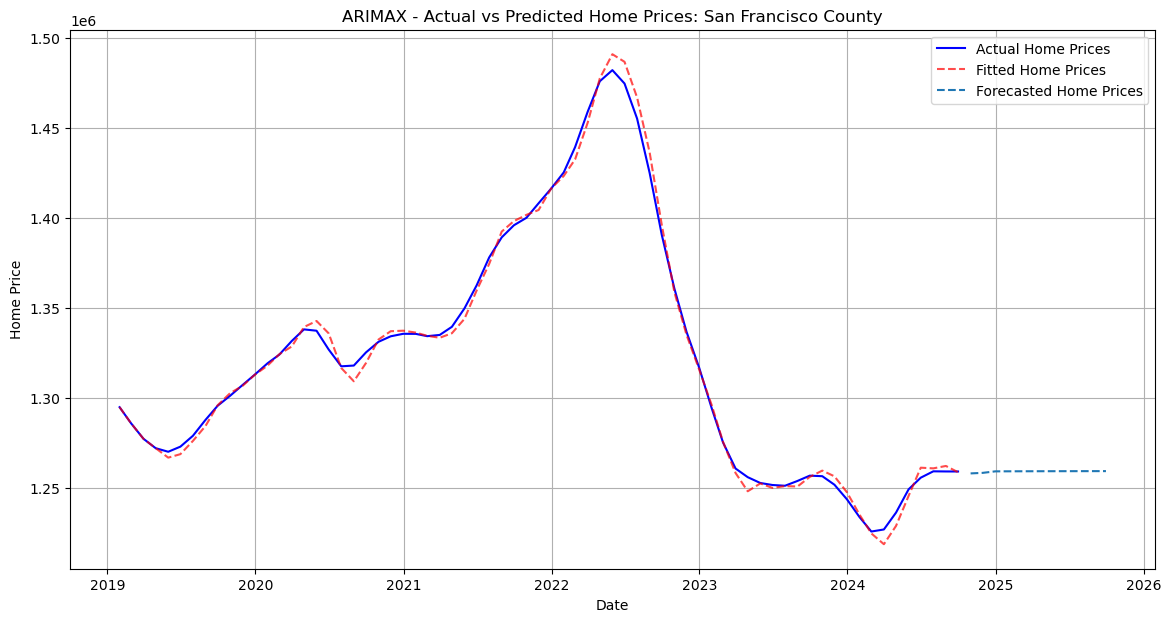

2024-10-31    1.258019e+06
2024-11-30    1.258327e+06
2024-12-31    1.259164e+06
2025-01-31    1.259185e+06
2025-02-28    1.259204e+06
2025-03-31    1.259222e+06
2025-04-30    1.259237e+06
2025-05-31    1.259251e+06
2025-06-30    1.259264e+06
2025-07-31    1.259275e+06
2025-08-31    1.259285e+06
2025-09-30    1.259294e+06
Freq: ME, Name: predicted_mean, dtype: float64


In [57]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load the dataset
file_path = './data/cleaned_all_datasets_joined.csv'
data = pd.read_csv(file_path)

# Filter the data for San Francisco County
sf_data = data[data['county'] == 'San Francisco County']

# Convert the date column to datetime format and sort the data by date
sf_data['date'] = pd.to_datetime(sf_data['date'])
sf_data = sf_data.sort_values(by='date')

# Remove duplicates and select necessary columns
sf_data_cleaned = sf_data.drop_duplicates(subset=['date'])
predictors = ['resident_population_per_county', 'median_household_income', 'totallisting_per_county']
sf_data_model = sf_data_cleaned[['date', 'home_price'] + predictors].set_index('date')

# Check and handle missing values
sf_data_model_cleaned = sf_data_model.fillna(method='ffill')

# Define the target variable and predictors
y_cleaned = sf_data_model_cleaned['home_price']
X_cleaned = sf_data_model_cleaned[predictors]

# Fit the ARIMAX model
model_cleaned = SARIMAX(y_cleaned, exog=X_cleaned, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
result_cleaned = model_cleaned.fit(disp=False)

# Get fitted values
fitted_values = result_cleaned.fittedvalues
fitted_values[0:4] = sf_data_model_cleaned['home_price'][0:4]
# Forecast for the next 12 months
forecast_steps = 12
forecast = result_cleaned.get_forecast(steps=forecast_steps, exog=X_cleaned.iloc[-forecast_steps:])
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Ensure numeric values in forecast results
forecast_ci = forecast_ci.applymap(lambda x: float(x) if isinstance(x, (int, float)) else None)
forecast_mean = forecast_mean.apply(lambda x: float(x) if isinstance(x, (int, float)) else None)

# Plot historical vs fitted vs forecasted home prices
plt.figure(figsize=(14, 7))
plt.plot(
    sf_data_model_cleaned.index,
    sf_data_model_cleaned['home_price'],
    label='Actual Home Prices',
    color ='blue',
)
plt.plot(
    fitted_values.index,
    fitted_values,
    label='Fitted Home Prices',
    linestyle='--',
    color='red',
    alpha=0.7
)
plt.plot(
    forecast_mean.index,
    forecast_mean,
    label='Forecasted Home Prices',
    linestyle='--'
)
plt.title('ARIMAX - Actual vs Predicted Home Prices: San Francisco County')
plt.xlabel('Date')
plt.ylabel('Home Price')
plt.legend()
plt.grid()
plt.show()

# Display forecasted values
print(forecast_mean)

In [59]:
import itertools
import numpy as np

# Define the range of p, d, q parameters to test
p = d = q = range(0, 3)  # Adjust range as needed
param_combinations = list(itertools.product(p, d, q))

# Grid search to find the best (p, d, q) parameters based on AIC
best_aic = np.inf
best_order = None
results = []

for order in param_combinations:
    try:
        # Fit SARIMAX model with the current order
        model = SARIMAX(y_cleaned, exog=X_cleaned, order=order, enforce_stationarity=False, enforce_invertibility=False)
        result = model.fit(disp=False)
        aic = result.aic
        results.append((order, aic))
        
        # Update the best parameters if current model is better
        if aic < best_aic:
            best_aic = aic
            best_order = order
    except Exception as e:
        # Skip models that fail to converge
        continue

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Order (p,d,q)', 'AIC']).sort_values(by='AIC')

print(results_df.head())  # Display the top results


C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  

   Order (p,d,q)          AIC
26     (2, 2, 2)  1234.892931
17     (1, 2, 2)  1241.408935
8      (0, 2, 2)  1246.014056
24     (2, 2, 0)  1250.342196
25     (2, 2, 1)  1252.340358


C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jpiao\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


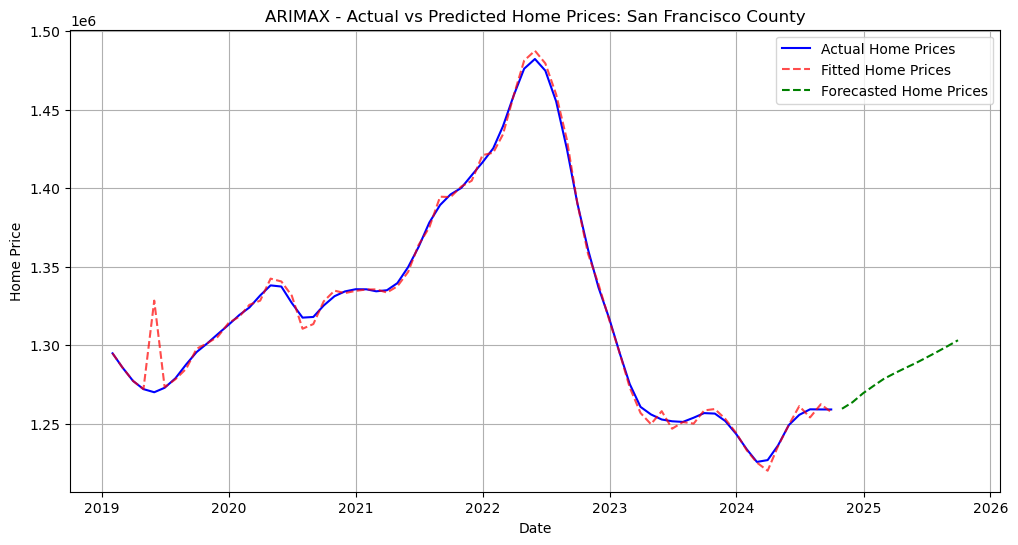

2024-10-31    1.259545e+06
2024-11-30    1.263650e+06
2024-12-31    1.269461e+06
2025-01-31    1.274281e+06
2025-02-28    1.278514e+06
2025-03-31    1.282112e+06
2025-04-30    1.285363e+06
2025-05-31    1.288605e+06
2025-06-30    1.292036e+06
2025-07-31    1.295674e+06
2025-08-31    1.299426e+06
2025-09-30    1.303183e+06
Freq: ME, Name: predicted_mean, dtype: float64


In [61]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Extract the best order from the results
best_order = results_df.iloc[0]['Order (p,d,q)']

# Refit the ARIMAX model with the best parameters
optimized_model = SARIMAX(
    y_cleaned,
    exog=X_cleaned,
    order=best_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
optimized_result = optimized_model.fit(disp=False)
# Get fitted values
fitted_values = optimized_result.fittedvalues
fitted_values[0:4] = sf_data_model_cleaned['home_price'][0:4]

# Forecast using the optimized model
optimized_forecast = optimized_result.get_forecast(steps=12, exog=X_cleaned.iloc[-12:])
optimized_forecast_mean = optimized_forecast.predicted_mean
optimized_forecast_ci = optimized_forecast.conf_int()

# Simplified plot: Historical vs Optimized Forecasted Home Prices without confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(
    sf_data_model_cleaned.index,
    sf_data_model_cleaned['home_price'],
    label='Actual Home Prices',
    color='blue'
)
plt.plot(
    fitted_values.index,
    fitted_values,
    label='Fitted Home Prices',
    linestyle='--',
    color='red',
    alpha=0.7
)
plt.plot(
    optimized_forecast_mean.index,
    optimized_forecast_mean,
    label='Forecasted Home Prices',
    linestyle='--',
    color='green'
)
plt.title('ARIMAX - Actual vs Predicted Home Prices: San Francisco County')
plt.xlabel('Date')
plt.ylabel('Home Price')
plt.legend()
plt.grid()
plt.show()

# Display the optimized forecasted mean values
print(optimized_forecast_mean)
